In [9]:
import cv2
import matplotlib.pyplot as plot
from skimage.feature import (match_descriptors,corner_harris,corner_peaks,ORB,plot_matches,BRIEF)
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

In [169]:
%matplotlib inline

In [170]:
#matriz camara
# -----------------------------------------------------------------------> 
K = np.array([[2759.48/4, 0, 1520.69/4, 0, 2764.16/4,1006.81/4, 0, 0, 1]]).reshape(3, 3)
d = np.array([0.0, 0.0, 0.0, 0.0, 0.0]).reshape(1, 5)
# ----------------------------------------------------------------------->
#K = np.array([56.9105,0,11.8698,0,56.9105,8.0418,0,0,1]).reshape(3, 3) #original tomada del .CAM
#d = np.array([8.641e-006, 0.0, 0.0, 0.0, 0.0]).reshape(1, 5) #matriz de distorsion original tomada del .CAM


In [173]:
#ruta = "img/candela/ZCH0001/"
#ruta = "img/candela/ZCH0131/"
ruta = "img/monumento/"
lstFiles = []
lstDir = os.walk(ruta)
for root, dirs, files in lstDir:
    for fichero in files:
        (nombreFichero, extension) = os.path.splitext(fichero)
        if(extension == ".png" or extension == ".JPG"):
            img = cv2.imread(ruta+nombreFichero+extension,cv2.CV_8UC3)
            #img = cv2.imread(ruta+nombreFichero+extension,1)
            if len(img1.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            #img = cv2.resize(img,(0,0),fx=0.5, fy=0.5)
            lstFiles.append(img)
            #print (nombreFichero+extension)

In [174]:
img1 = lstFiles[1]
img2 = lstFiles[0]

#redimencion
if img1.shape[1] > 600:
    while img1.shape[1] > 2*600:
        img1 = cv2.pyrDown(img1)
        img2 = cv2.pyrDown(img2)

img1 = cv2.undistort(img1, K, d)
img2 = cv2.undistort(img2, K, d)

#plot.imshow(img2)
#plot.show()

In [175]:
#ORB

#orb = cv2.ORB_create(1000)
#first_key_points, first_desc = orb.detectAndCompute(img1,None)
#second_key_points, second_desc = orb.detectAndCompute(img2,None)

orb = cv2.SURF(250)
first_key_points, first_desc = orb.detectAndCompute(img1,None)
second_key_points, second_desc = orb.detectAndCompute(img2,None)

# match descriptors
matcher = cv2.BFMatcher(cv2.NORM_L1, True)
matches = matcher.match(first_desc, second_desc)

# generate lists of point correspondences
first_match_points = np.zeros((len(matches), 2), dtype=np.float32)
second_match_points = np.zeros_like(first_match_points)

for i in range(len(matches)):
    first_match_points[i] = first_key_points[matches[i].queryIdx].pt
    second_match_points[i] = second_key_points[matches[i].trainIdx].pt
    

In [176]:
#matches = sorted(matches, key = lambda x:x.distance)
#img4 = cv2.drawMatches(img1,first_key_points,img2,second_key_points,matches,None)
#plot.imshow(img4)


In [177]:
first_match_points.shape

(695, 2)

In [178]:
#matriz fundamental
retval,mask=cv2.findFundamentalMat(first_match_points,second_match_points,cv2.FM_RANSAC, 0.1, 0.99)
#Matriz esencial
E = K.T.dot(retval).dot(K)

In [179]:
#funcion que permite determinar si lo puntos se encuentra frente a la camara o no
def _in_front_of_both_cameras(first_points, second_points, rot, trans):
    rot_inv = rot
    for first, second in zip(first_points, second_points):
        first_z = np.dot(rot[0, :] - second[0]*rot[2, :],trans) / np.dot(rot[0, :] - second[0]*rot[2, :],second)
        first_3d_point = np.array([first[0] * first_z,second[0] * first_z, first_z])
        second_3d_point = np.dot(rot.T, first_3d_point) - np.dot(rot.T,trans)
        if first_3d_point[2] < 0 or second_3d_point[2] < 0:
            return False
    return True

In [180]:
#procedimiento dudoso

first_inliers = []
second_inliers = []
for i in range(len(mask)):
    if mask[i]:
        # normalize and homogenize the image coordinates
        first_inliers.append(np.linalg.inv(K).dot([first_match_points[i][0],first_match_points[i][1], 1.0]))
        second_inliers.append( np.linalg.inv(K).dot([second_match_points[i][0],second_match_points[i][1], 1.0]))

U,s,V= np.linalg.svd(E,full_matrices=False)
W = np.array([0.0, -1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,1.0]).reshape(3, 3)
R = U.dot(W).dot(V) # U*W*V.T --> otra biblografia
T = U[:,2]


if not _in_front_of_both_cameras(first_inliers,second_inliers,R, T):
    # Second choice: R = U * W * Vt, T = -u_3
    T = - U[:, 2]
if not _in_front_of_both_cameras(first_inliers,second_inliers,R, T):
    # Third choice: R = U * Wt * Vt, T = u_3
    R = U.dot(W.T).dot(V)
    T = U[:, 2]
    if not _in_front_of_both_cameras(first_inliers,second_inliers, R, T):
        # Fourth choice: R = U * Wt * Vt, T = -u_3
        T = - U[:, 2]
        
first_inliers = np.array(first_inliers)
second_inliers = np.array(second_inliers)


In [181]:
#validando matriz de rotacion ---> si el determinante es 1 o -1 todo OK.
np.linalg.det(R)

1.0000000000000004

In [182]:
#P1 =np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]]) #matriz de camara canonica! manera pro: 
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = np.hstack((R, T.reshape(3, 1))) # P2 = [R|T]
#P2 = np.array([[R[0][0],R[0][1],R[0][2],T[0]],[R[1][0],R[1][1],R[1][2],T[1]],[R[2][0],R[2][1],R[2][2],T[2]]]) #[R|t]

In [183]:
first_inliers1 = first_inliers.reshape(-1, 3)[:, :2]
second_inliers2 = second_inliers.reshape(-1,3)[:,:2]
triangulacion = cv2.triangulatePoints(P1,P2,first_inliers1.T,second_inliers2.T).T

In [184]:
#triangulacion


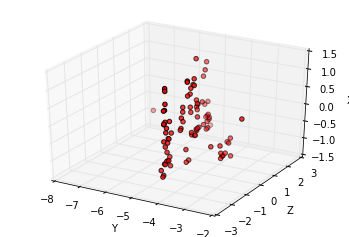

In [185]:
pts3D = triangulacion[:, :3]/np.repeat(triangulacion[:, 3], 3).reshape(-1, 3)
# plot with matplotlib
Ys = pts3D[:, 0]
Zs = pts3D[:, 1]
Xs = pts3D[:, 2]
# ------------------------->
fig = plot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs, Ys, Zs, c='r', marker='o')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')

plot.show()
# ------------------------->
#fig = plot.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot3D(X, Y, Z)
#plot.show()

In [166]:
import pcl

In [167]:
cloud = pcl.PointCloud(np.array(pts3D, dtype=np.float32))

In [168]:
cloud._to_pcd_file("prueba.pcd")

0